This notebook shows how to use the `sentinel_segmentation` to train and test the image segmentation model for Sentinel-2.

### **Notice**
Before running this section, please run the code in `download.ipynb` to download the dataset and pre-trained model.

### Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler
from sentinel_segmentation.data_loader import SegmentationDataset, compute_mean_std, get_aug
from sentinel_segmentation.models import UnetPlusPlusResnet50WithDropout
from sentinel_segmentation.loss_function import CombinedLoss
from sentinel_segmentation.training import train_model
from sentinel_segmentation.evaluation import evaluate_model
from sentinel_segmentation.evaluation import show_predictions


/Users/yc4523/Desktop/irp_updated/s2s/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Calculate mean and std values of the dataset

In [3]:
mean, std = compute_mean_std('downloads/dataset/train/images')
print(f"Mean: {mean}, Std: {std}")

Mean: [ 45.34097168  74.43581726  90.87697571  41.01965881 166.26754395
  90.48647217], Std: [34.95595393 42.80975712 42.47460187 49.92024694 62.11734168 51.81708918]


### Load dataset

In [4]:
color_to_label = {
    (0, 0, 0): 0,    # background - black
    (255, 0, 0): 1,  # harbor - red
    (0, 255, 0): 2,  # jetty - green
    (0, 0, 255): 3   # resort - blue
}

In [5]:
train_dataset = SegmentationDataset(
    images_dir='downloads/dataset/train/images',
    masks_dir='downloads/dataset/train/masks',
    img_size=(128, 128),
    color_to_label=color_to_label,
    mean=mean,
    std=std,
    augmentations=get_aug()
)

val_dataset = SegmentationDataset(
    images_dir='downloads/dataset/val/images',
    masks_dir='downloads/dataset/val/masks',
    img_size=(128, 128),
    color_to_label=color_to_label,
    mean=mean,
    std=std,
)

test_dataset = SegmentationDataset(
    images_dir='downloads/dataset/test/images',
    masks_dir='downloads/dataset/test/masks',
    img_size=(128, 128),
    color_to_label=color_to_label,
    mean=mean,
    std=std,
)

augment_multiplier = 5

# Augment and sample the training set
train_sampler = RandomSampler(train_dataset, replacement=True, num_samples=len(train_dataset) * augment_multiplier)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=16, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Define the model

In [6]:
model = UnetPlusPlusResnet50WithDropout(dropout_p=0.5)
model = model.to(device)

The models in this project are all trained on Google Colab.
 
If you don’t want to train the model from scratch, you can skip this step and use the pre-trained model.

### Model training

#### Define the loss function

In [7]:
class_counts = [15878233, 239011, 29359, 106325]
total_count = sum(class_counts)
cls_weights = [total_count / count for count in class_counts]
cls_weights = torch.tensor(cls_weights, dtype=torch.float32).to(device)

criterion = CombinedLoss(weight_dice=0.5, weight_focal=0.5,
                         cls_weights=cls_weights,
                         use_dice_weight=False, use_focal_weight=False,
                         use_focal=True)


#### Set Up the Parameters

In [8]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                              lr=1e-4, weight_decay=5e-4)

In [9]:
# train_losses, val_losses, train_mious, val_mious, val_recalls = train_model(
#     model, train_loader, val_loader, criterion, optimizer, device, num_epochs=120, save_path='downloads/trained_model/best_model.pth'
# )


#### Plot training and val loss 

In [10]:
# # Plotting the training and validation loss
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Val Loss')
# plt.legend()
# plt.show()

# # Plotting the training and validation mIoU
# plt.plot(train_mious, label='Train mIoU')
# plt.plot(val_mious, label='Val mIoU')
# plt.legend()
# plt.show()

# # Plotting the validation recall
# plt.plot(val_recalls, label='Val Recall')
# plt.legend()
# plt.show()


### Model test

#### Load the pre-trained model

In [11]:
model = UnetPlusPlusResnet50WithDropout(dropout_p=0.5)
model.load_state_dict(torch.load('downloads/trained_model/UnetPlusPlus-Resnet50.pth', map_location=device))
model = model.to(device)
model.eval()

/var/folders/b3/k0w8k2kd1s78zzp67h0d95900000gp/T/ipykernel_50306/32440920.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('downloads/tra

UnetPlusPlusResnet50WithDropout(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [12]:
evaluate_model(model, test_loader, 4, device)

Class 0: IoU = 0.9914, Dice = 0.9957,Precision = 0.9972,Recall = 0.9942, F1 Score = 0.9957
Class 1: IoU = 0.6145, Dice = 0.7612,Precision = 0.6954,Recall = 0.8409, F1 Score = 0.7612
Class 2: IoU = 0.3505, Dice = 0.5190,Precision = 0.4491,Recall = 0.6148, F1 Score = 0.5190
Class 3: IoU = 0.5935, Dice = 0.7449,Precision = 0.6976,Recall = 0.7990, F1 Score = 0.7449

Test Mean IoU: 0.6375, Test Accuracy: 0.9914, Test Mean Dice: 0.7552
Test Mean Precision: 0.7098, Test Mean Recall: 0.8122, Test Mean F1 Score: 0.7552
Balanced Accuracy: 0.8122


{'iou': 0.6374550461769104,
 'accuracy': 0.9913849830627441,
 'dice': 0.7552006840705872,
 'precision': 0.7098003029823303,
 'recall': 0.8122165203094482,
 'f1': 0.755200207233429,
 'balanced_accuracy': 0.8122165359535907,
 'confusion_matrix': tensor([[4.3318e+05, 1.2780e+03, 3.5700e+02, 8.9300e+02],
         [5.4600e+02, 2.9170e+03, 6.0000e+00, 0.0000e+00],
         [1.4500e+02, 0.0000e+00, 3.0000e+02, 4.3000e+01],
         [5.3800e+02, 0.0000e+00, 5.0000e+00, 2.1590e+03]], dtype=torch.float64)}

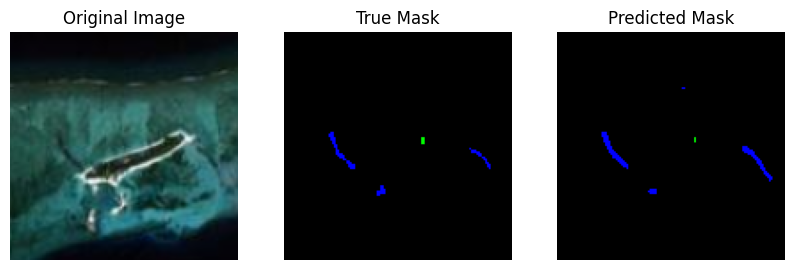

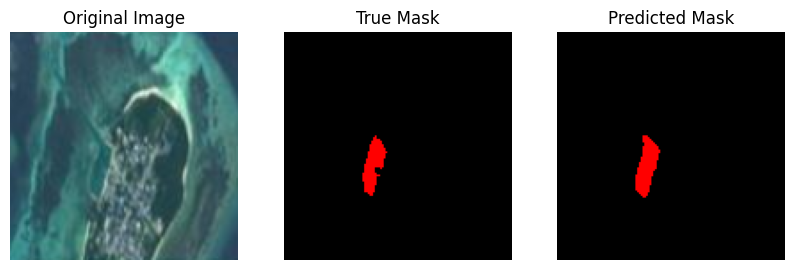

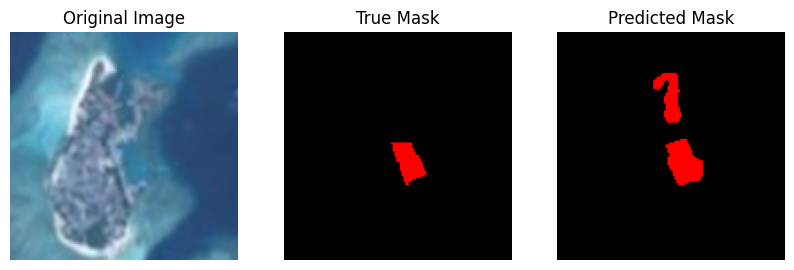

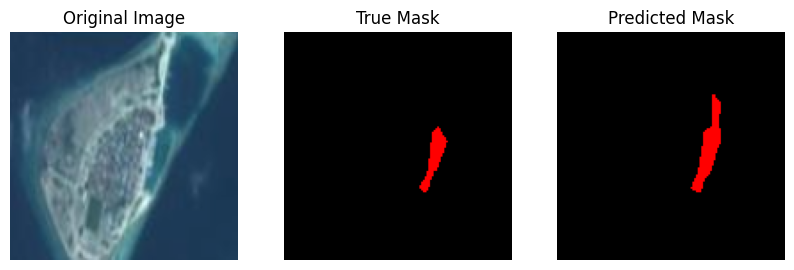

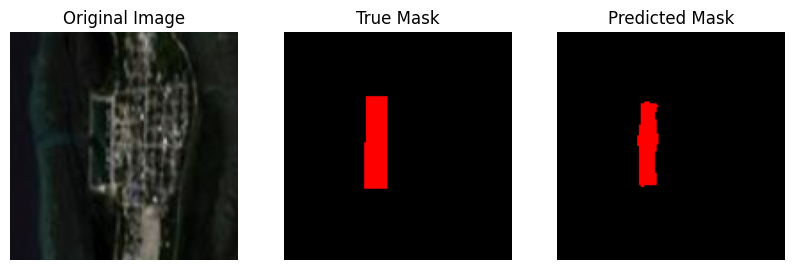

In [13]:
show_predictions(model, test_loader, device, color_to_label, mean, std, num_images=5)